<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/xgb_mortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Model for Mortality Rate Prediction
In this example, we will learn how to build a model for predicting mortality rate with <code>xgboost</code> and <code>VitalDB</code> dataset.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below. 
</b> If you do not agree, please close this window. 
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

In [1]:
!pip install -q xgboost
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve, auc

# Load datasets
df = pd.read_csv('https://api.vitaldb.net/cases')
df['sex'] = (df['sex'] == 'M')

# Remove categorical variables
df = df.drop(['department','optype', 'dx', 'opname', 'approach', 'position', 'ane_type', 'cormack', 'airway', 'tubesize', 'dltubesize', 'lmasize', 'lmasize', 'preop_ecg', 'preop_pft', 'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2'], axis=1)
df = df.astype(float)

# Remove outcome variables
y = df['death_inhosp'].values.flatten()
df = df.drop(['death_inhosp','caseid','subjectid','icu_days','casestart','caseend','anestart','aneend','opstart','opend','adm','dis'], axis=1)

# Input variables
x = df.values

df.columns

Index(['age', 'sex', 'height', 'weight', 'bmi', 'asa', 'emop', 'preop_htn',
       'preop_dm', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt',
       'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast',
       'preop_alt', 'preop_bun', 'preop_cr', 'preop_ph', 'preop_hco3',
       'preop_be', 'preop_pao2', 'preop_paco2', 'preop_sao2', 'intraop_ebl',
       'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid',
       'intraop_colloid', 'intraop_ppf', 'intraop_mdz', 'intraop_ftn',
       'intraop_rocu', 'intraop_vecu', 'intraop_eph', 'intraop_phe',
       'intraop_epi', 'intraop_ca'],
      dtype='object')

4791 (event 0.9%) training, 1597 testing (event 0.9 %) samples
optimal thval: 0.022829512134194374
auroc: 0.808, auprc: 0.566	acc: 0.971	f1: 0.277	TN 1541	fp 42	fn 5	TP 9


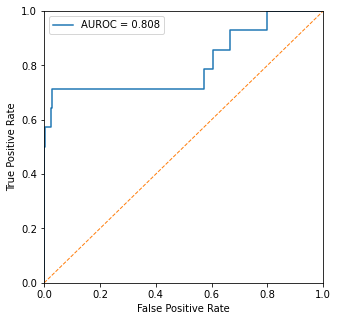

In [2]:
nsamp = len(x)

# Split the dataset into train and test sets.
ntest = int(nsamp * 0.25)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
x_train = x[:-ntest, :]
y_train = y[:-ntest]
print('{} (event {:.1f}%) training, {} testing (event {:.1f} %) samples'.format(ntrain, np.mean(y_train) * 100 , ntest, np.mean(y_test) * 100))

# Build and fit the model
model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=50, max_depth=3).fit(x_train, y_train)

# Predict the data
y_pred = model.predict_proba(x_test)[:, 1].ravel()

# Test the final model
fpr, tpr, thvals = roc_curve(y_test, y_pred)
auroc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
optimal_idx = np.argmax(tpr - fpr)
thval = thvals[optimal_idx]

print('optimal thval: {}'.format(thval))
y_pred = y_pred > thval
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('auroc: {:.3f}, auprc: {:.3f}\tacc: {:.3f}\tf1: {:.3f}\tTN {}\tfp {}\tfn {}\tTP {}'.format(auroc, auprc, acc, f1, tn, fp, fn, tp))

# Draw a graph
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='AUROC = {:0.3f}'.format(auroc))
plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()